# Brain Cancer Classification With a Quantum Hybrid-Classical Model <🧠|1>

## 👉 Objectives
Classifying different Brain Cancer Types based on MRI images using a Quantum Hybrid-Classical Model then Comprare the results with a Classical Model (DenseNet121)

## 👉 Importing needed libraries

In [2]:
# QML
import pennylane as qml

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import umap
import cv2
from sklearn.model_selection import train_test_split


# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
from pennylane import numpy as np


## 👉 Data Analysis

In this section we are going to introduce the used dataset and do some visualization in order to explore its contents

### About the dataset

The dataset has been downloaded from figshare website [link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

It is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    - cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    - cjdata.PID: patient ID
    - cjdata.image: image data
    - cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            - For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            - It was generated by manually delineating the tumor border. So we can use it to generate
            - binary image of tumor mask.
    - cjdata.tumorMask: a binary image with 1s indicating tumor region

### Visualize the data

#### Labels

In [3]:
# Counting labels
folder = "../brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('../brain_tumor_dataset/all/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

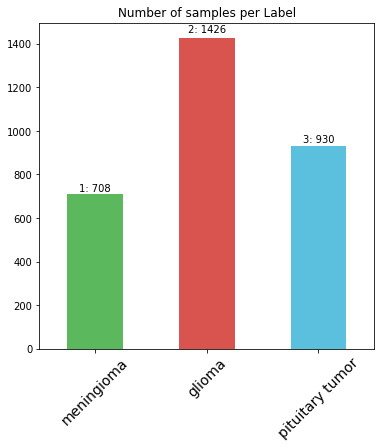

In [1000]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#5cb85c', '#d9534f', '#5bc0de'],
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=45)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1


#### Pictures

In [941]:
folder = "../brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

((3,), (3, 512, 512, 4), (3, 512, 512))

In [952]:
b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape

(3, 512, 512)


(3, 512, 512, 3)

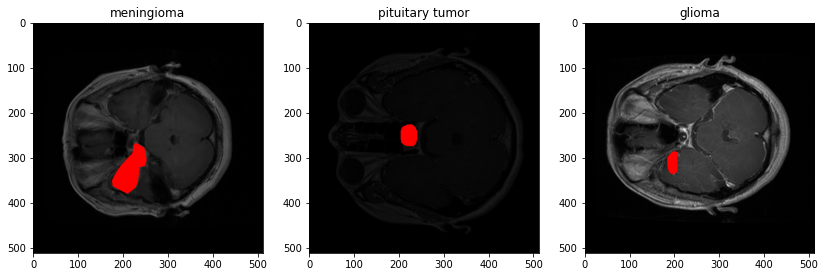

In [951]:
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])

plt.show()

## 👉 Model

In this section we will talk about our model and how we designed it

### Architecture

Based on classical Convolutional Neural Network Architecture (fig. 1) and pure Quantum Convolutional Neural Network (fig. 2) we came out with the Quantum Hybrid-Classical presented in the (fig. 3)

##### 👇 Fig. 1: Simple Convolutional Neural Network

<hr>

![CNN](CNN.png)

<br>

##### 👇 Fig. 2: Quantum Convolutional Neural Network

<hr>

![QCNN](QCNN1.png)

<br>

##### 👇 Fig. 3: Our Quantum Hybrid-Classical Convolutional Neural Network

<hr>

![Model](Model.jpg)

<br>



Resources

<hr>

[- CNN](https://www.researchgate.net/publication/331540139_A_State-of-the-Art_Survey_on_Deep_Learning_Theory_and_Architectures/figures?lo=1&utm_source=google&utm_medium=organic)
<br>
[- QCNN](https://arxiv.org/pdf/2009.09423.pdf)
<br>
[- Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_quanvolution.html?fbclid=IwAR3Sw-OvDokiY1bzltvyyLHnnlPvlVTnAiwH3HqjTYpLxnjSbibGBfaSmTA)

### First part: Features Extraction

<hr>
Defining Quantum Circuit and Quantum Convolutional function

In [42]:
wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])

    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 2
    out = np.zeros(((H//step), (W//step)))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # average pooling of each 4x4 pixels
            #px0 = X[i:i+step2, j:j+step2].mean()
            #px1 = X[i:i+step2, j+step2:j+step].mean()
            #px2 = X[i+step2:i+step, j:j+step2].mean()
            #px3 = X[i+step2:i+step, j+step2:j+step].mean()

            #phi = np.array([px0, px1, px2, px3])

            phi = X[i:i+2, j:j+2].flatten()
            # Get Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


<hr>
Visualizing Quantum Circuit

In [15]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))

 0: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╭RZ(1.57)──╭RX(1.57)──┤ ⟨Z⟩ 
 1: ──RX(3.14)──╰C─────────╰C─────────│──────────│──────────┤     
 2: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╰C─────────╰C─────────┤     
 3: ──RX(3.14)──╰C─────────╰C───────────────────────────────┤     



<hr>

Applying the Quantum Convolutional Layer

In [ ]:
# Images processing with a Quantum Convolutional Layer
folder = "../brain_tumor_dataset/all/" # .mat files folder
processFolder = "../brain_tumor_dataset/processed/allresized/"
start = timer()
w = 512
step = 2 # 8

k = 0
directs = sorted(listdir(folder))

for file in directs:
    all64 = sorted(listdir(processFolder))
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    NorImages = resized/255

    processed = QCONV1(NorImages, str(k)+" "+file, (len(directs)-len(all64))/2, step)

    np.savez_compressed(processFolder+file, image=processed, label=label)
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

<hr>
Visualization after applying quantum filter

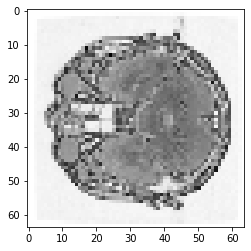

In [49]:
img = np.load("../brain_tumor_dataset/processed/allresized/1000.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()


### Second part: Classification

<hr>
Get processed images coupled with their labels + augment some of them

In [148]:
# get processed data
folder = "../brain_tumor_dataset/processed/allresized/"
directs = sorted(listdir(folder))

data_augmentation = K.Sequential([
  K.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #K.layers.experimental.preprocessing.RandomRotation(0.2),
])
images = []
masks = []
labels = []
i = 0
for file in directs:
    try:
        data = np.load(folder+file)
        label = data["label"]
        img = np.stack((data["image"],), axis=-1)
        images.append(img)
        labels.append(label)
        if label == 1:
            aimg = tf.expand_dims(img, 0)
            augmented_image = data_augmentation(aimg)
            images.append(augmented_image[0])
            labels.append(data["label"])
        i+=1
    except:
        continue

npimages = np.asarray(images) # np.stack((images,), axis=-1)
nplabels = np.asarray(labels)

In [149]:
npimages.shape, nplabels.shape#, npmasks.shape ==1438

((3757, 64, 64, 1), (3757,))

<hr>

Splitting the data to 3 parts train/validation/test

In [150]:
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [151]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((2629, 64, 64, 1),
 (564, 64, 64, 1),
 (564, 64, 64, 1),
 (564,),
 (2629,),
 (564,))

<hr>

Defining Fully Connected Layers with Tensorflow

In [262]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(64, activation="relu"),
        K.layers.Dropout(0.5),
        K.layers.Dense(4, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

<hr>

Train the model

In [270]:
### tf.random.set_seed(42)
q_model = Model()
checkpoint_path = "checkpoints/quantum.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=20,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/20
165/165 - 2s - loss: 1.0178 - accuracy: 0.5234 - val_loss: 0.6682 - val_accuracy: 0.7624
Epoch 2/20
165/165 - 1s - loss: 0.7543 - accuracy: 0.6154 - val_loss: 0.5673 - val_accuracy: 0.7677
Epoch 3/20
165/165 - 1s - loss: 0.6611 - accuracy: 0.6729 - val_loss: 0.5021 - val_accuracy: 0.8262
Epoch 4/20
165/165 - 1s - loss: 0.6266 - accuracy: 0.7140 - val_loss: 0.4679 - val_accuracy: 0.8174
Epoch 5/20
165/165 - 1s - loss: 0.5562 - accuracy: 0.7258 - val_loss: 0.4615 - val_accuracy: 0.8387
Epoch 6/20
165/165 - 1s - loss: 0.5446 - accuracy: 0.7413 - val_loss: 0.4302 - val_accuracy: 0.8351
Epoch 7/20
165/165 - 1s - loss: 0.5151 - accuracy: 0.7619 - val_loss: 0.4225 - val_accuracy: 0.8227
Epoch 8/20
165/165 - 1s - loss: 0.4536 - accuracy: 0.7851 - val_loss: 0.4351 - val_accuracy: 0.8121
Epoch 9/20
165/165 - 1s - loss: 0.4527 - accuracy: 0.7878 - val_loss: 0.3542 - val_accuracy: 0.8723
Epoch 10/20
165/165 - 1s - loss: 0.4900 - accuracy: 0.7531 - val_loss: 0.3737 - val_accuracy: 0.8582

<hr>

Plotting the results

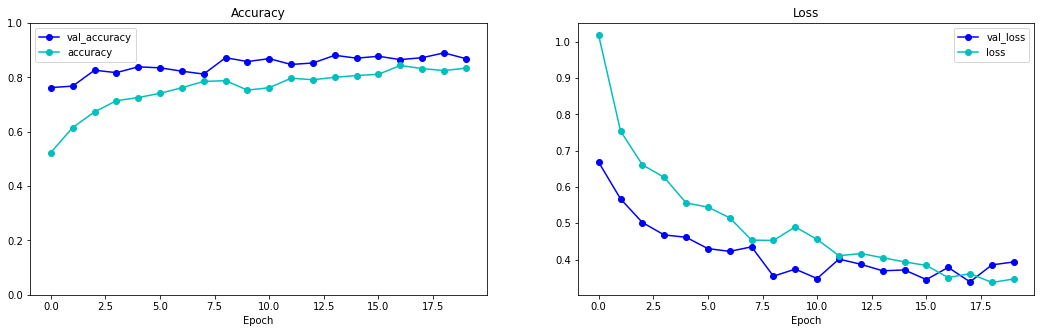

In [271]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

## 👉 Evaluation
<hr>

Defining a method to plot the Confusion Matrix

In [272]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<hr>
Get predicted labels

In [273]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [274]:
yhat.shape, y_test.shape

((564,), (564,))

<hr>

Printing the classification report using Sklearn

In [275]:
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

         1.0       0.85      0.72      0.78       218
         2.0       0.79      0.86      0.82       195
         3.0       0.85      0.93      0.89       151

    accuracy                           0.83       564
   macro avg       0.83      0.84      0.83       564
weighted avg       0.83      0.83      0.83       564



<hr>

Computing & Plotting Confusion Matrix

Confusion matrix, without normalization


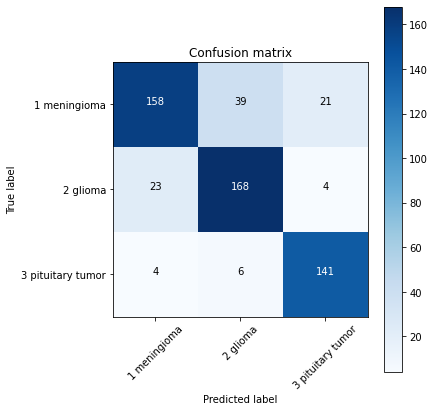

In [276]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

# 👉 Classical

In [3]:
# Images resizing
folder = "../brain_tumor_dataset/all/" # .mat files folder

w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
images = []
labels = []

for file in directs:

    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue

    label = np.array(f.get("cjdata/label"))[0][0]

    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    images.append(np.stack((resized,), axis=-1))
    labels.append(label)
    print("image "+str(k)+"  ", end="\r")

    k+=1
images = np.asarray(images)/255
labels = np.asarray(labels)

In [4]:
images.shape

(3049, 128, 128, 1)

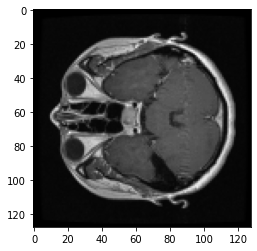

In [5]:
plt.imshow(resized, "gray")

<hr>

Splitting the data to 3 parts train/validation/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2134, 128, 128, 1), (458, 128, 128, 1), (2134,), (458,))

<hr>

Defining the DenseNet121 Model & Training it

[- Resource](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet121)


In [11]:
# create DenseNet121 Model
model = K.applications.DenseNet121(
    weights=None,
    input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    classes=4,
)
# compile the model
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
checkpoint_path = "checkpoints/classical.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=20,
    verbose=1,
    callbacks=[cp_callback]
)

Epoch 1/20
134/134 [==============================] - 1833s 13s/step - loss: 0.8789 - accuracy: 0.6437 - val_loss: 2.2952 - val_accuracy: 0.3690
Epoch 2/20
134/134 [==============================] - 1645s 12s/step - loss: 0.5921 - accuracy: 0.7339 - val_loss: 2.4686 - val_accuracy: 0.5502
Epoch 3/20
134/134 [==============================] - 1486s 11s/step - loss: 0.5699 - accuracy: 0.7536 - val_loss: 6.9083 - val_accuracy: 0.4651
Epoch 4/20
134/134 [==============================] - 1444s 11s/step - loss: 0.4929 - accuracy: 0.7651 - val_loss: 0.6361 - val_accuracy: 0.6987
Epoch 5/20
134/134 [==============================] - 1713s 13s/step - loss: 0.4196 - accuracy: 0.8139 - val_loss: 0.7528 - val_accuracy: 0.7205
Epoch 6/20
134/134 [==============================] - 1499s 11s/step - loss: 0.4248 - accuracy: 0.8082 - val_loss: 0.3896 - val_accuracy: 0.8231
Epoch 7/20
134/134 [==============================] - 1470s 11s/step - loss: 0.3719 - accuracy: 0.8313 - val_loss: 4.7299 - val_ac

<hr>

Plotting the results

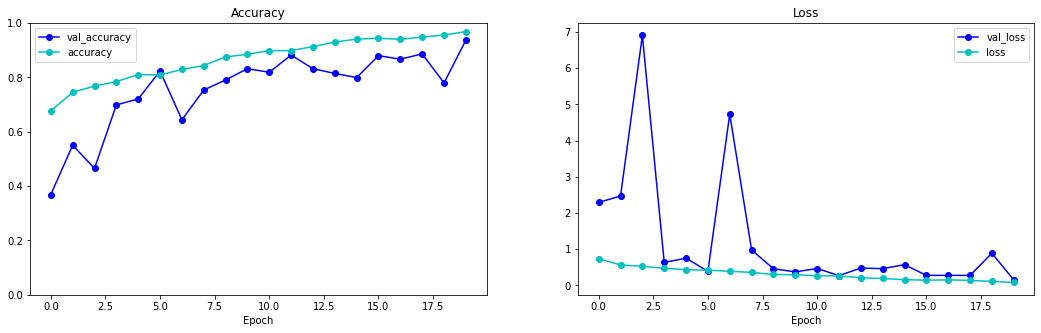

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

## 👉 Evaluation
<hr>

Get Predicted labels

In [13]:
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

<hr>

Printing the classification report using Sklearn

In [14]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.93      0.84      0.88       113
         2.0       0.92      0.97      0.94       213
         3.0       0.98      0.97      0.97       132

    accuracy                           0.94       458
   macro avg       0.94      0.93      0.93       458
weighted avg       0.94      0.94      0.94       458



<hr>

Computing & Plotting Confusion Matrix

Confusion matrix, without normalization


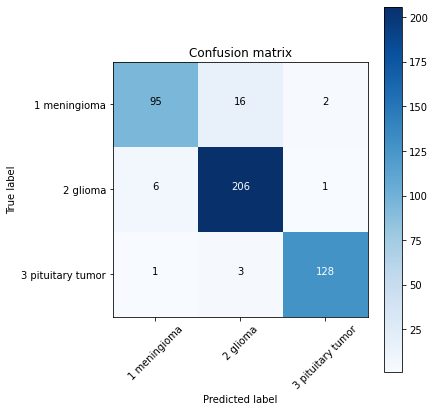

In [15]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

### Extra Ressources

- [Pennylane](https://pennylane.ai/)

- [Qiskit](https://qiskit.org/)

- [Quantum Computing Concepts – Entanglement](https://www.youtube.com/watch?v=EjdIMBOWCWo)

- []()